This code is to display the experimental results in the paper "Gradient Normalization Makes Heterogeneous Distributed
Learning as Easy as Homogenous Distributed Learning" by Tao Sun.

In [16]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

## Notations

n : the number of nodes

m : the number of local data samples within each node

d : dimension of the feature vectors

i : node index

## logistic regression utilities

Consider the logistic regression problem: 

$\min\ F(w) = \frac{1}{n}\sum_{i=1}^n f_i(w) + \rho r(w)$ where $f_i(w) = \frac{1}{m}\sum_{l=1}^m \ln(1 + \exp(-y_{i,l} x_{i,l}^T w))$, and $r(w) = \sum_{j=1}^d \frac{w(j)^2}{1 + w(j)^2}$ is a non-convex regularization term.

Subscript $i$ indicates the node index, and $l$ indicates the local data index. Data samples $\{x_{i,l}, y_{i,l}\}_{l=1}^m$ are kept locally in node $i$.

The gradient can be calculated as follow:

The gradient of $\frac{1}{n}\sum_{i=1}^n f_i(w)$ is: $\nabla \frac{1}{n}\sum_{i=1}^n f_i(w) = \frac{1}{nm}\sum_{i=1}^n\sum_{l=1}^m \beta_{i,l} y_{i,l} x_{i,l}$ 

where $\beta_{i,l} = \frac{\exp(-y_{i,l} x_{i,l}^T w)}{1 + \exp(-y_{i,l} x_{i,l}^T w)}$.

Problems: {The gradient of $r(w)$ is: $\nabla r(w) = \sum_{i=1}^d \frac{2 w(j)}{(1+w(j)^2)^2}$}

The gradient of $r(w)$ is: $\nabla r_j(w) = \frac{2 w(j)}{(1+w(j)^2)^2}$

In [2]:
# Generate full gradient of the logistic regression problem

def lr_full_grad(X, y, w, rho):  
    
    _, M = X.shape
    
    prob = np.exp(- y * X.dot(w)) 
    alpha = prob / (1 + prob)
    
    # r_grad = 2*rho*np.sum(w/((1+w*w)*(1+w*w)))
    r_grad = 2 * rho * (w/((1+w*w)*(1+w*w))).reshape(M, 1)

    grad = r_grad - np.mean(alpha*y*X, axis = 0).reshape(M, 1)
    
    return grad

In [3]:
# Generate full local gradient at W
# G has dimensions (n, M), which stacks each local gradient one by one

def lr_full_grad_dist(X, y, W, rho):
    
    total_sample_size, M = X.shape
    n = W.shape[0]
    S = total_sample_size//n    
    
    G = np.zeros((n, M))
    
    for i in range(n):
        
        wi = W[i,:].reshape(M, 1)        
        Xi = X[i*S:(i+1)*S, :]
        yi = y[i*S:(i+1)*S].reshape(S, 1)
        
        prob = np.exp(- yi * Xi.dot(wi))
        beta = prob / (1 + prob)   

        # r_grad = 2*rho*np.sum(wi/((1+wi*wi)*(1+wi*wi)))    
        r_grad = 2 * rho * (wi/((1+wi*wi)*(1+wi*wi))).reshape(M, 1)    

        grad = r_grad - np.mean(beta*yi*Xi, axis = 0).reshape(M, 1)
        G[i,:] = grad.T
    
    return G

In [4]:
# Generate stochastic local gradient at W
# G has dimensions (n, M), which stacks each local gradient one by one

def lr_sto_grad_dist(X, y, W, rho):  
    
    total_sample_size, M = X.shape
    n = W.shape[0]
    S = total_sample_size//n 
    
    G = np.zeros((n, M))
    s = np.random.randint(1,S)
    for i in range(n):
        
        wi = W[i,:].reshape(M, 1)        
        Xi = X[[i*S + s], :]
        yi = y[i*S + s]
        
        prob = np.exp(- yi * Xi.dot(wi))
        beta = prob / (1 + prob)

        # r_grad = 2*rho*np.sum(wi/((1+wi*wi)*(1+wi*wi)))
        r_grad = 2 * rho * (wi/((1+wi*wi)*(1+wi*wi))).reshape(M, 1)

        grad = r_grad - (beta*yi*Xi).reshape(M, 1)
        G[i,:] = grad.T
    
    return G

In [5]:
# Generate mini-batch stochastic local gradient at W
# G has dimensions (n, M), which stacks each local gradient one by one
# n_1 is the batch size

def lr_part_sto_grad_dist(X,y,W,rho): 
    
    total_sample_size, M = X.shape
    n = W.shape[0]
    S = total_sample_size//n    
    n_1 = 20    
    G = np.zeros((n, M))
    for i in range(n):

        a = np.random.choice(S,n_1,replace=False) + i*S
        wi = W[i,:].reshape(M, 1) 
        Xi = X[a, :]
        yi = y[a].reshape(n_1,1)
        
        prob = np.exp(- yi * Xi.dot(wi))
        beta = prob / (1 + prob)

        # r_grad = 2*rho*np.sum(wi/((1+wi*wi)*(1+wi*wi)))
        r_grad = 2 * rho * (wi/((1+wi*wi)*(1+wi*wi))).reshape(M, 1)

        grad = r_grad - np.mean((beta*yi*Xi),axis = 0).reshape(M, 1)
        G[i,:] = grad.T
    
    return G

### Fedavg

In [6]:
def fedavg_stochastic(X, y, n, step_size, period = 20, noise = 1e-2, outloop=100, epochs=10):

    grad_norm_mean = np.zeros((outloop+1, 1))
    R = np.ones((n,n))/n
    grad_norm = np.zeros((outloop+1, 1))
    for e in range(epochs):
        
        #if (e+1)%1 == 0:
            #print('FedAvg epoch index:', e)
    
        W = np.zeros((n, M))
        Y = np.zeros((n, M))

        w_ave = np.mean(W, axis=0).reshape(M, 1)
        g = lr_full_grad(X,y,w_ave,rho)
        grad_norm[0] = np.linalg.norm(g,2)

        for ite in range(outloop):

            # local update
            Y = np.copy(W)
            for k in range(period):
                G = lr_part_sto_grad_dist(X, y, Y, rho) + noise * np.random.randn(n, M)
                Y = Y - step_size * G
            
            W = R.dot(Y)

            # record gradient norm
            w_ave = np.mean(W, axis=0).reshape(M, 1) 
            g = lr_full_grad(X, y, w_ave, rho) 
            grad_norm[ite+1] = np.linalg.norm(g, 2) 

        grad_norm_mean += grad_norm
        
    grad_norm_mean = grad_norm_mean/epochs
        
    return grad_norm_mean

### Momentum FedAvg

In [ ]:
def fedavg_stochastic(X, y, n, step_size, period = 20, noise = 1e-2, outloop=100, epochs=10):

    grad_norm_mean = np.zeros((outloop+1, 1))
    R = np.ones((n,n))/n
    grad_norm = np.zeros((outloop+1, 1))
    for e in range(epochs): 
         
        #if (e+1)%1 == 0:
            #print('FedAvg epoch index:', e)
    
        W = np.zeros((n, M))
        Y = np.zeros((n, M))

        w_ave = np.mean(W, axis=0).reshape(M, 1)
        g = lr_full_grad(X,y,w_ave,rho)
        grad_norm[0] = np.linalg.norm(g,2)

        for ite in range(outloop):

            # local update
            Y = np.copy(W)
            for k in range(period):
                G = lr_part_sto_grad_dist(X, y, Y, rho) + noise * np.random.randn(n, M)
                Y = Y - step_size * G
            
            W = R.dot(Y)

            # record gradient norm
            w_ave = np.mean(W, axis=0).reshape(M, 1) 
            g = lr_full_grad(X, y, w_ave, rho) 
            grad_norm[ite+1] = np.linalg.norm(g, 2) 

        grad_norm_mean += grad_norm
        
    grad_norm_mean = grad_norm_mean/epochs
        
    return grad_norm_mean

### Normalized Fedavg

In [7]:
def gradient_normalization_fedavg_lr(X, y, n, L, sigma2, w0,theta,gamma,eta, K = 20, noise = 1e-2, T = 100,epochs =10):

    M = X.shape[1]    
    G = np.zeros((n,M))   
    grad_norm = np.zeros((T+1,1))
    grad_norm_mean = np.zeros((T+1,1))
    for e in range(epochs):
        W = np.zeros((n, M))
        m = np.zeros((n,M))
        Y = np.zeros((n, M))


        w = w0
        g = lr_full_grad(X,y,w0.T,rho)
        grad_norm[0] = np.linalg.norm(g,2)

        for t in range(T):

            # local update
            for i in range(n):
                Y[i] = w
                W[i] = w
            for k in range(K):
                G = lr_part_sto_grad_dist(X,y,Y,rho) + noise * np.random.randn(n, M)  
                Y = Y-eta*G
                
            # update w with the norm of momentum
            m = theta*m+((1-theta)/(K*eta))*(W-Y)
            w = w-gamma*np.sum(m,axis=0) /(np.linalg.norm(np.sum(m,axis=0)))

            # record gradient norm
            g = lr_full_grad(X,y,w.T,rho)
            grad_norm[t+1] = np.linalg.norm(g,2)
        grad_norm_mean += grad_norm
    grad_norm_mean = grad_norm_mean/epochs
    return grad_norm_mean

### Generate non-iid synthesized data

In [15]:
# To generate the non-iid data later, we should first generate a bunch of data from N classes here.
# n : the number of workers
# N : the number of data classes

def lr_generate_base_data(base_data_size,n,M,W0,N):  

    S = base_data_size//N
    X0 = np.zeros((base_data_size,M))
    y0 = np.zeros((base_data_size,1))
    for i in range(N):
        meani = np.array([(i+1)/6 for k in range(M)])
        #meani = np.array([0 for k in range(M)])
        cov = 3*np.eye(M)
        wi = W0[i,:].reshape(M, 1)
        Xi = np.random.multivariate_normal(meani,cov,S)
        #Xi = np.random.randn(S, M)
        yi = np.random.uniform(0.3+(i)/(2*N)-1/(8*N),0.3+(i+1)/(2*N)+1/(8*N),size=(S,1)) < 1 / (1 + np.exp(-Xi.dot(wi)))
        #yi = np.random.uniform(0,1,size=(S,1)) < 1 / (1 + np.exp(-Xi.dot(wi)))  
        yi = yi.astype(int)
        
        X0[i*S:(i+1)*S, :] = Xi
        y0[i*S:(i+1)*S] = yi
        
    return X0,y0

In [ ]:
# Based on the data from different N classes, we can generate non-iid data by using Dirichlet

def lr_generate_noniid_data(total_sample_size,X0,y0,n,p0,alpha,N):

    M = X0.shape[1]
    base_data_size = X0.shape[0]
    S = total_sample_size//n    # data size of each worker
    S1 = base_data_size//N    # data size of each class
    X = np.zeros((total_sample_size,M))
    y = np.zeros((total_sample_size,1))
    q = np.random.dirichlet(alpha*p0,n)   # the dimension of q is (n,N)
    for i in range(n):
        class_labels = np.random.choice(N,size = S,p=q[i])
        sample_labels = np.random.choice(S1,size = S)
        Xi = np.zeros((S,M))
        yi = np.zeros((S,1))

        # sample non-iid data from X0,y0 which store the different N classes data
        for k in range(S):
            c = class_labels[k]
            s = sample_labels[k]
            Xi[k] = X0[c*S1+s]
            yi[k] = y0[c*S1+s]

        X[i*S:(i+1)*S,:] = Xi
        y[i*S:(i+1)*S] = yi
    y = 2*y-1
    return X,y

In [ ]:
np.random.seed(2023)
n, M = 100, 5 # n is the amount of worker, M is the local data dimension
total_sample_size = n * 1000 # 1000 is the local data size 
base_data_size = total_sample_size * 10
rho = 0.001
N = 40 

W0 = np.zeros((N, M)) 
for k in range(N):
    w_0k = np.random.normal(k/4-N/8,10, M)
    #w_0k = np.random.randn(1,M)
    #w_0k = w_0k/np.linalg.norm(w_0k)
    W0[k, :] = w_0k # non-iid scenario
X0,y0 = lr_generate_base_data(base_data_size,n,M,W0,N)


# the bigger alpha means less significant data heterogeneity
alpha1,alpha2,alpha3= 2.5, 0.5, 0.1
L = 1
var = np.var(X0,axis=0)
sigma2 = max(var) + 0.1
p0 = np.ones(N)/N
X1,y1 = lr_generate_noniid_data(total_sample_size,X0,y0,n,p0,alpha1,N)
X3,y3 = lr_generate_noniid_data(total_sample_size,X0,y0,n,p0,alpha3,N)
X2,y2 = lr_generate_noniid_data(total_sample_size,X0,y0,n,p0,alpha2,N)

### Results on synthesized dataset

Text(0, 0.5, 'gradient norm')

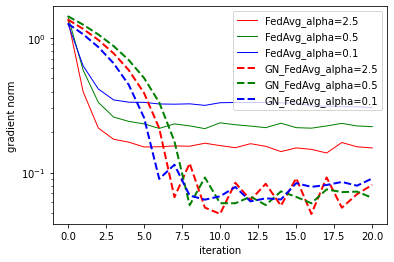

In [17]:
step_size, K, T, epochs = 0.01, 10, 20, 10   
noise1 = 0.2
noise2 = 0.2
theta = 0.2  # np.random.uniform(0.15,0.35)
gamma = 0.01  # np.random.uniform(0.002,0.01)
eta = 0.00001  # np.random.uniform(0.005,0.095)
w0 = np.zeros((1,M))

grad_norm_mean_fa1 = fedavg_stochastic(X1, y1, n, step_size=step_size, period = K, noise = noise1, outloop = T, epochs=epochs)
grad_norm_mean_fa2 = fedavg_stochastic(X2, y2, n, step_size=step_size, period = K, noise = noise1, outloop = T, epochs=epochs)
grad_norm_mean_fa3 = fedavg_stochastic(X3, y3, n, step_size=step_size, period = K, noise = noise1, outloop = T, epochs=epochs)

grad_norm_mean_gnfa1 = gradient_normalization_fedavg_lr(X1, y1, n, L, sigma2,w0,theta,gamma,eta, K = K, noise = noise2, T = T,epochs =epochs)
w0 = np.zeros((1,M))
grad_norm_mean_gnfa2 = gradient_normalization_fedavg_lr(X2, y2, n, L, sigma2,w0,theta,gamma,eta, K = K, noise = noise2, T = T,epochs =epochs)
w0 = np.zeros((1,M))
grad_norm_mean_gnfa3 = gradient_normalization_fedavg_lr(X3, y3, n, L, sigma2,w0,theta,gamma,eta, K = K, noise = noise2, T = T,epochs =epochs)
x_arr = np.arange(0, grad_norm_mean_fa3.shape[0], 1) 

plt.semilogy(x_arr, grad_norm_mean_fa1[x_arr], linewidth=1.0, color='red',linestyle='solid')
plt.semilogy(x_arr, grad_norm_mean_fa2[x_arr], linewidth=1.0, color='green',linestyle='solid')
plt.semilogy(x_arr, grad_norm_mean_fa3[x_arr], linewidth=1.0, color='blue',linestyle='solid')
plt.semilogy(x_arr, grad_norm_mean_gnfa1[x_arr], linewidth=2.0, color='red',linestyle='dashed')
plt.semilogy(x_arr, grad_norm_mean_gnfa2[x_arr], linewidth=2.0, color='green',linestyle='dashed')
plt.semilogy(x_arr, grad_norm_mean_gnfa3[x_arr], linewidth=2.0, color='blue',linestyle='dashed')

plt.legend(['FedAvg_alpha=2.5', 'FedAvg_alpha=0.5','FedAvg_alpha=0.1','GN_FedAvg_alpha=2.5','GN_FedAvg_alpha=0.5','GN_FedAvg_alpha=0.1'], fontsize=10)
plt.xlabel('iteration', fontsize = 10)
plt.ylabel('gradient norm', fontsize = 10)


### Generate non-iid data on MNIST dataset

In [17]:
# Generate base data from 10 classes according to the label of MNIST (each label corresponds to a class)
# because the amount of data from each class is different, so we need to use d to store the data size of each class.

def lr_generate_base_data_mnist(): 
 
    (X_train, y_train), _ = mnist.load_data()

    X0 = np.zeros((60000, 28, 28))
    y0 = np.zeros(60000).astype(int)
    l = 0
    d = np.zeros(10).astype(int)
    for i in range(10):
        A = np.argwhere(y_train == i).flatten()   # the dimension (28,28) will be flattened to 784
        X0[l:l+len(A)] = X_train[A]
        
        if i <= 4:
            y0[l:l+len(A)] = 1
        else:
            y0[l:l+len(A)] = 0
        
        #y0[l:l+len(A)]=y_train[A]
        l += len(A)
        d[i] = len(A)
    
    return X0,y0,d

In [18]:
# Generate non-iid data from 10 classes 

def lr_generate_noniid_data_mnist(total_sample_size,X0,y0,n,p0,alpha,N,d):

    M = X0[0].flatten().shape[0]
    S = total_sample_size//n
    X = np.zeros((total_sample_size,M))
    y = np.zeros((total_sample_size,1))
    q = np.random.dirichlet(alpha*p0,n)   
    for i in range(n):
        class_labels = np.random.choice(N,size = S,p=q[i])
        Xi = np.zeros((S,M))
        yi = np.zeros((S,1))

        # sample non-iid data from X0,y0 which store the different N classes data
        for k in range(S):
            c = class_labels[k]
            s = np.random.choice(d[c])
            begin = np.sum(d[0:c])
            Xi[k] = X0[begin+s].flatten()
            yi[k] = y0[begin+s]
            
        X[i*S:(i+1)*S,:] = Xi
        y[i*S:(i+1)*S] = yi
    y = 2*y-1
    return X,y

In [ ]:
np.random.seed(2023)
n, M = 100, 784 # n is the amount of worker, M is the local data dimension
total_sample_size = n * 600 # 600 is the local data size 
rho = 0.001
N = 10 

X0,y0,d = lr_generate_base_data_mnist()


alpha1,alpha2,alpha3= 2.5, 0.5, 0.1
L = 1
var = np.var(X0,axis=0)
sigma2 = 100
p0 = np.ones(N)/N
X1,y1 = lr_generate_noniid_data_mnist(total_sample_size,X0,y0,n,p0,alpha1,N,d)
X3,y3 = lr_generate_noniid_data_mnist(total_sample_size,X0,y0,n,p0,alpha3,N,d)
X2,y2 = lr_generate_noniid_data_mnist(total_sample_size,X0,y0,n,p0,alpha2,N,d)

### Results on MNIST dataset

In [12]:
step_size, K, T, epochs = 0.00000015, 30, 500, 1
noise1 = 0.1
noise2 = 0.1
theta = 0.9#np.random.uniform(0.15,0.35)
gamma = 0.00008#np.random.uniform(0.002,0.01)
eta = 0.00000001#np.random.uniform(0.005,0.095)
w0 = np.zeros((1,M))

grad_norm_mean_fa1 = fedavg_stochastic(X1, y1, n, step_size=step_size, period = K, noise = noise1, outloop = T, epochs=epochs)
grad_norm_mean_fa2 = fedavg_stochastic(X2, y2, n, step_size=step_size, period = K, noise = noise1, outloop = T, epochs=epochs)
grad_norm_mean_fa3 = fedavg_stochastic(X3, y3, n, step_size=step_size, period = K, noise = noise1, outloop = T, epochs=epochs)

grad_norm_mean_gnfa1 = gradient_normalization_fedavg_lr(X1, y1, n, L, sigma2,w0,theta,gamma,eta, K = K, noise = noise2, T = T,epochs =epochs)

grad_norm_mean_gnfa2 = gradient_normalization_fedavg_lr(X2, y2, n, L, sigma2,w0,theta,gamma,eta, K = K, noise = noise2, T = T,epochs =epochs)

grad_norm_mean_gnfa3 = gradient_normalization_fedavg_lr(X3, y3, n, L, sigma2,w0,theta,gamma,eta, K = K, noise = noise2, T = T,epochs =epochs)


In [13]:

def min(grad_norm_mean):
    T = grad_norm_mean.shape[0]
    grad_norm_min = np.zeros(T)
    for i in range(T):
        grad_norm_min[i] = np.min(grad_norm_mean[0:i+1])
    return grad_norm_min

min_grad_norm_mean_fa1 = min(grad_norm_mean_fa1)
min_grad_norm_mean_fa2 = min(grad_norm_mean_fa2)
min_grad_norm_mean_fa3 = min(grad_norm_mean_fa3)

min_grad_norm_mean_gnfa1 = min(grad_norm_mean_gnfa1)
min_grad_norm_mean_gnfa2 = min(grad_norm_mean_gnfa2)
min_grad_norm_mean_gnfa3 = min(grad_norm_mean_gnfa3)

a = np.max(np.concatenate((min_grad_norm_mean_fa1,min_grad_norm_mean_fa2,min_grad_norm_mean_fa3,min_grad_norm_mean_gnfa1,min_grad_norm_mean_gnfa2,min_grad_norm_mean_gnfa3)))

min_grad_norm_mean_fa1 = min(grad_norm_mean_fa1)/a
min_grad_norm_mean_fa2 = min(grad_norm_mean_fa2)/a
min_grad_norm_mean_fa3 = min(grad_norm_mean_fa3)/a

min_grad_norm_mean_gnfa1 = min(grad_norm_mean_gnfa1)/a
min_grad_norm_mean_gnfa2 = min(grad_norm_mean_gnfa2)/a
min_grad_norm_mean_gnfa3 = min(grad_norm_mean_gnfa3)/a

Text(0, 0.5, 'gradient norm')

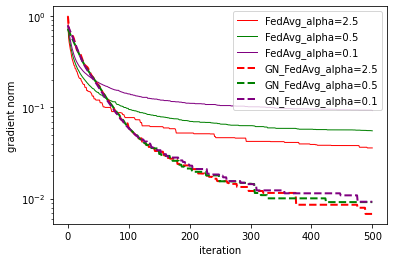

In [14]:
x_arr = np.arange(0, grad_norm_mean_gnfa3.shape[0], 1) 
plt.semilogy(x_arr, min_grad_norm_mean_fa1[x_arr], linewidth=1.0, color='red',linestyle='solid')
plt.semilogy(x_arr, min_grad_norm_mean_fa2[x_arr], linewidth=1.0, color='green',linestyle='solid')
plt.semilogy(x_arr, min_grad_norm_mean_fa3[x_arr], linewidth=1.0, color='purple',linestyle='solid')
plt.semilogy(x_arr, min_grad_norm_mean_gnfa1[x_arr], linewidth=2.0, color='red',linestyle='dashed')
plt.semilogy(x_arr, min_grad_norm_mean_gnfa2[x_arr], linewidth=2.0, color='green',linestyle='dashed')
plt.semilogy(x_arr, min_grad_norm_mean_gnfa3[x_arr], linewidth=2.0, color='purple',linestyle='dashed')

plt.legend(['FedAvg_alpha=2.5', 'FedAvg_alpha=0.5','FedAvg_alpha=0.1','GN_FedAvg_alpha=2.5','GN_FedAvg_alpha=0.5','GN_FedAvg_alpha=0.1'], fontsize=10)
plt.xlabel('iteration', fontsize = 10)
plt.ylabel('gradient norm', fontsize = 10)